# Mandatory import Statements

In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

# Used a code to calaculate the hamiltonian in the possible pauli tensored basis

In [2]:
# Used this code from another location to decompose the 2-qubit hamiltonian of interest
def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print ("%s\t*\t( %s )" % (c2s(a_ij), label))

In [3]:
H = np.array(
    [[1, 0, 0, 0], 
    [0, 0, -1, 0],
    [0, -1, 0, 0], 
    [0, 0, 0, 1]]
    , dtype=np.complex128)
decompose(H)

0.5	*	( I \otimes I )
-0.5	*	( sigma_x \otimes sigma_x )
-0.5	*	( sigma_y \otimes sigma_y )
0.5	*	( sigma_z \otimes sigma_z )


# Defined the various measurement circuits and corresponding functions to calculate the expectations
Given, H = $\frac{1}{2}(\mathbb{1} \otimes \mathbb{1} + Z \otimes Z - X \otimes X - Y \otimes Y)$ <br>
Let,
- $H_{1} = \mathbb{1} \otimes \mathbb{1}$
- $H_{2} = Z \otimes Z$
- $H_{3} = X \otimes X$
- $H_{4} = Y \otimes Y$, then, $\langle H \rangle = \frac{1}{2}\langle H_{1} \rangle + \frac{1}{2}\langle H_{2} \rangle - \frac{1}{2}\langle H_{3} \rangle - \frac{1}{2}\langle H_{4} \rangle$ and $\langle H_{1} \rangle = 1$

Also Tested for initial values of theta = 0

In [4]:
def prepare_ansatz_circuit(angle1):

    ansatz_circ = QuantumCircuit(2)
    ansatz_circ.h(0)
    ansatz_circ.barrier()
    ansatz_circ.cx(0, 1)
    ansatz_circ.barrier()
    ansatz_circ.rx(angle1, 0)
    ansatz_circ.barrier()


    
    return ansatz_circ 

In [5]:
from math import pi
ansatz_circ = prepare_ansatz_circuit(0)
ansatz_circ.draw()

┌───┐ ░       ░ ┌───────┐ ░ 
q_0: ┤ H ├─░───■───░─┤ RX(0) ├─░─
     └───┘ ░ ┌─┴─┐ ░ └───────┘ ░ 
q_1: ──────░─┤ X ├─░───────────░─
           ░ └───┘ ░           ░

In [6]:
def measure_zz_circuit(given_circuit):
    zz_meas = given_circuit.copy()
    zz_meas.measure_all()
    return zz_meas
zz_meas = measure_zz_circuit(ansatz_circ)
zz_meas.draw()

┌───┐ ░       ░ ┌───────┐ ░  ░ ┌─┐   
   q_0: ┤ H ├─░───■───░─┤ RX(0) ├─░──░─┤M├───
        └───┘ ░ ┌─┴─┐ ░ └───────┘ ░  ░ └╥┘┌─┐
   q_1: ──────░─┤ X ├─░───────────░──░──╫─┤M├
              ░ └───┘ ░           ░  ░  ║ └╥┘
meas_0: ════════════════════════════════╩══╬═
                                           ║ 
meas_1: ═══════════════════════════════════╩═

In [7]:
simulator = Aer.get_backend('qasm_simulator')

In [8]:
def measure_zz(given_circuit, num_shots = 10000, noise_model=None, basis_gates=None, coupling_map=None):

    zz_meas = measure_zz_circuit(given_circuit)
    
    result = execute(zz_meas, backend = simulator,noise_model=noise_model,coupling_map=coupling_map, shots = num_shots).result()
    counts = result.get_counts(zz_meas)
    plot_histogram(counts)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zz = counts['00'] + counts['11'] - counts['01'] - counts['10']
    zz = zz / total_counts
    
    return zz

In [9]:
zz = measure_zz(ansatz_circ)
print("<ZZ> =", str(zz))

<ZZ> = 1.0


In [10]:
def measure_xx_circuit(given_circuit):
    xx_meas = given_circuit.copy()
    for i in range(2):
        xx_meas.h(i)
    
    xx_meas.measure_all()
    
    return xx_meas

In [11]:
xx_meas = measure_xx_circuit(ansatz_circ)
xx_meas.draw()

┌───┐ ░       ░ ┌───────┐ ░ ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─░───■───░─┤ RX(0) ├─░─┤ H ├─░─┤M├───
        └───┘ ░ ┌─┴─┐ ░ └───────┘ ░ ├───┤ ░ └╥┘┌─┐
   q_1: ──────░─┤ X ├─░───────────░─┤ H ├─░──╫─┤M├
              ░ └───┘ ░           ░ └───┘ ░  ║ └╥┘
meas_0: ═════════════════════════════════════╩══╬═
                                                ║ 
meas_1: ════════════════════════════════════════╩═

In [12]:
def measure_xx(given_circuit, num_shots = 10000, noise_model=None, coupling_map=None):
    
    xx_meas = measure_xx_circuit(given_circuit)
    
    result = execute(xx_meas, backend = simulator,noise_model=noise_model,
                     coupling_map=coupling_map, shots = num_shots).result()
    counts = result.get_counts(xx_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    xx = counts['00'] + counts['11'] - counts['01'] - counts['10']
    xx = xx / total_counts
    
    return xx

xx = measure_xx(ansatz_circ)
print("<XX> =", str(xx))

<XX> = 1.0


In [13]:
def measure_yy_circuit(given_circuit):
    yy_meas = given_circuit.copy()
    for i in range(2):
        yy_meas.rx(pi/2, i)
    
    yy_meas.measure_all()
    
    return yy_meas

In [14]:
yy_meas = measure_yy_circuit(ansatz_circ)
yy_meas.draw()

┌───┐ ░       ░ ┌───────┐ ░ ┌──────────┐ ░ ┌─┐   
   q_0: ┤ H ├─░───■───░─┤ RX(0) ├─░─┤ RX(pi/2) ├─░─┤M├───
        └───┘ ░ ┌─┴─┐ ░ └───────┘ ░ ├──────────┤ ░ └╥┘┌─┐
   q_1: ──────░─┤ X ├─░───────────░─┤ RX(pi/2) ├─░──╫─┤M├
              ░ └───┘ ░           ░ └──────────┘ ░  ║ └╥┘
meas_0: ════════════════════════════════════════════╩══╬═
                                                       ║ 
meas_1: ═══════════════════════════════════════════════╩═

In [15]:
def measure_yy(given_circuit, num_shots = 10000, noise_model=None, coupling_map=None):
    
    yy_meas = measure_yy_circuit(given_circuit)
    
    result = execute(yy_meas, backend = simulator,noise_model=noise_model,coupling_map=coupling_map, shots = num_shots).result()
    counts = result.get_counts(yy_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    yy = counts['00'] + counts['11'] - counts['01'] - counts['10']
    yy = yy / total_counts
    
    return yy

yy = measure_yy(ansatz_circ)
print("<YY> =", str(yy))

<YY> = -1.0


# Energy calculation for the particular hamiltonian

In [16]:
def get_energy(given_circuit, num_shots = 10000, noise_model=None, coupling_map=None):
    
    zz = measure_zz(given_circuit, num_shots = num_shots, noise_model=noise_model, coupling_map=coupling_map)
    yy = measure_yy(given_circuit, num_shots = num_shots, noise_model=noise_model, coupling_map=coupling_map)
    xx = measure_xx(given_circuit, num_shots = num_shots, noise_model=noise_model, coupling_map=coupling_map)
#     print(xx, yy, zz)
    energy = (0.5)*1 + (-0.5)*xx + (-0.5)*yy + (0.5)*zz
#     print(energy)
    return energy

In [17]:
energy = get_energy(ansatz_circ)
print("The energy of the trial state is", str(energy))

The energy of the trial state is 1.0


# Here we define the final function and iterate over theta from 0 to 2 pi

In [18]:
def calculate_lowest_eigen(num_shots=10000, noise_model=None, coupling_map=None):
    theta_range = np.linspace(0, 2 * np.pi, 500)
    expectation_values = {}
    for theta in theta_range:
        ansatz_circ = prepare_ansatz_circuit(theta)
        expectation_values[theta] = get_energy(ansatz_circ, num_shots = num_shots, noise_model=noise_model, coupling_map = coupling_map)
    return expectation_values

# Checking plots for various values of num_shots/iterations

In [19]:
expectations = {}
expectations[10] = calculate_lowest_eigen(num_shots=10)

expectations[1000] = calculate_lowest_eigen(num_shots=1000)

expectations[10000] = calculate_lowest_eigen(num_shots=10000)

In [20]:
for i in {10, 1000, 10000}:
    print("Minimum energy/hence the eigenvalue for {} iterations is {}".format(i, min(expectations[i].values())))

Minimum energy/hence the eigenvalue for 1000 iterations is -1.0
Minimum energy/hence the eigenvalue for 10000 iterations is -1.0
Minimum energy/hence the eigenvalue for 10 iterations is -1.0


# Plot the eigenvalues against theta for various cases of shot numbers starting from 10, 1000, 10000

In [21]:
import matplotlib.pylab as plt
def plot(dictionary):
    lists = sorted(dictionary.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.xlabel("Value of theta in radians")
    plt.ylabel("Energy value(in Hartrees)")
    plt.plot(x, y)
    plt.show()
    

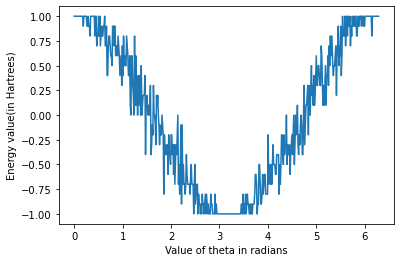

In [22]:
plot(expectations[10])

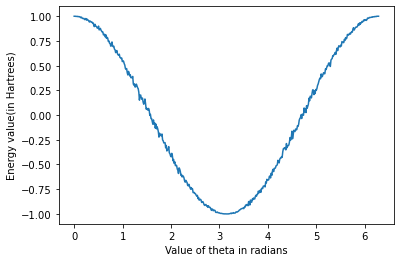

In [23]:
plot(expectations[1000])

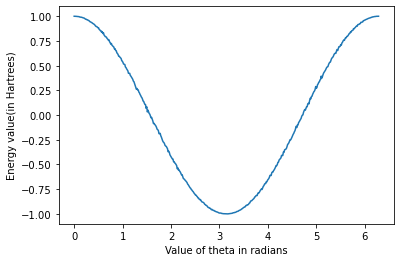

In [24]:
plot(expectations[10000])

# Effects of noise model (for iteration 10000) using ibm backend fake_tokyo

In [26]:
from qiskit.test.mock import FakeTokyo
from qiskit.providers.aer.noise import NoiseModel

backend = FakeTokyo()

noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
# basis_gates = noise_model.basis_gates
backend

<FakeTokyo('fake_tokyo') from None()>

In [38]:
expectations["with_noise"] = calculate_lowest_eigen(num_shots=10000, noise_model=noise_model, coupling_map=coupling_map)

In [39]:
print("Minimum energy/hence the eigenvalue for {} iterations with noise is {}".format(10000, min(expectations["with_noise"].values())))

Minimum energy/hence the eigenvalue for 10000 iterations with noise is -0.5842


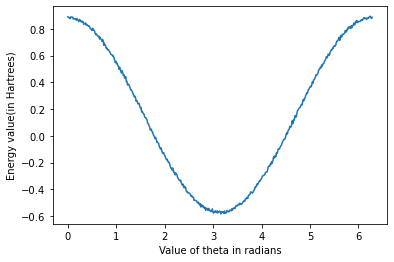

In [40]:
plot(expectations["with_noise"])

# Superposed plot with noise and without noise

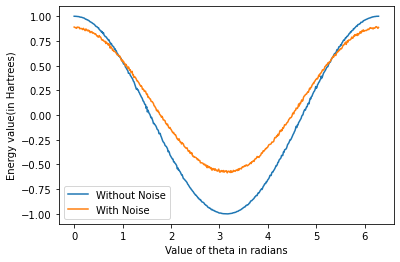

In [42]:
x1 = list(expectations[10000].keys())

y1 = list(expectations[10000].values())


x2 = list(expectations["with_noise"].keys())

y2 = list(expectations["with_noise"].values())

plt.xlabel("Value of theta in radians")
plt.ylabel("Energy value(in Hartrees)")
plt.plot(x1, y1)

plt.plot(x2, y2)
plt.legend(["Without Noise", "With Noise"])
plt.show()